In [ ]:

select * from information_schema.columns
where table_catalog <> ''
order by table_name,ordinal_position


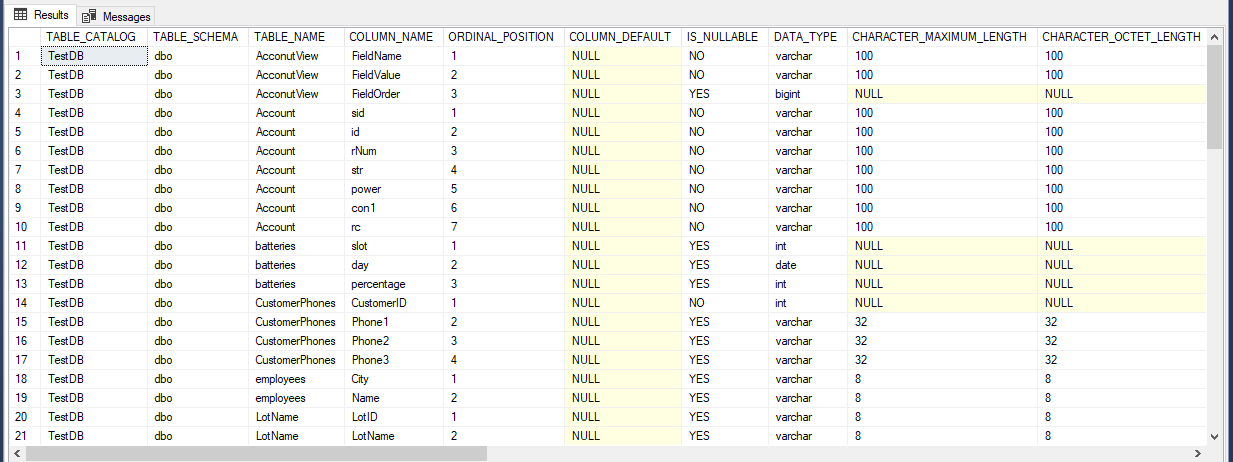

In [56]:

Image(filename='C:/Users/ryans/OneDrive/Desktop/all_tables_and_all_columns.PNG',width=1000, height=500)
    

In [ ]:

Let's find the top 10 longest running Stored Procedures in our database; we want to know where the bottlenecks are



SELECT TOP 10 
   ProcedureName    = t.text, 
   ExecutionCount   = s.execution_count, 
   AvgExecutionTime = isnull( s.total_elapsed_time / s.execution_count, 0 ),
   AvgWorkerTime    = s.total_worker_time / s.execution_count,
   TotalWorkerTime  = s.total_worker_time,
   MaxLogicalReads  = s.max_logical_reads, 
   MaxLogicalWrites = s.max_logical_writes, 
   CreationDateTime = s.creation_time,
   CallsPerSecond   = isnull( s.execution_count / datediff( second, s.creation_time, getdate()), 0 )
FROM sys.dm_exec_query_stats s
   CROSS APPLY sys.dm_exec_sql_text( s.sql_handle )  t
-- WHERE ...
ORDER BY 
   s.total_elapsed_time DESC


In [ ]:

Note: when I ran this on machine, I got no results, but it's only because I'm running this on a new instance of SQL Server.  If you run this on your own SQL Server, you will see a list of your top 10 longest running SProcs.
    

In [ ]:

Find which database on your server contains a Stored Procedure with a specific name.

A server can contain 32,767 seperate and distinct SQL databases.  If you know the name of the SProc you are looking for, but you don't remember which DB it sits in, this can help you find exactly what you are looking for!




DECLARE @SQL NVARCHAR(max)
,@spName VARCHAR(100) = 'usp_list_views' -- Note: the name of your SProc goes here...

SELECT @SQL = STUFF((
    SELECT ' UNION ALL 
SELECT ' + quotename(NAME, '''') + ' AS Db_Name FROM ' + quotename(NAME) + '.INFORMATION_SCHEMA.Routines 
    WHERE ROUTINE_NAME = @spName AND ROUTINE_TYPE = ''PROCEDURE'''
    FROM sys.databases
    ORDER BY NAME
FOR XML PATH('')
,TYPE
).value('.', 'nvarchar(max)'), 1, 11, '')

PRINT @SQL

EXECUTE sp_executeSQL @SQL
,N'@spName varchar(100)'
,@spName



In [ ]:

Let's use a script to find a string, by scanning through all tables in a database.  If you know what you are looking for, but can't remember which table has the data element that you need, this concept can be very useful!



DECLARE @SearchStr nvarchar(100) = 'FastCarsCo' 
DECLARE @Results TABLE (ColumnName nvarchar(370), ColumnValue nvarchar(3630))

SET NOCOUNT ON

DECLARE @TableName nvarchar(256), @ColumnName nvarchar(128), @SearchStr2 nvarchar(110)
SET  @TableName = ''
SET @SearchStr2 = QUOTENAME('%' + @SearchStr + '%','''')

WHILE @TableName IS NOT NULL

BEGIN
    SET @ColumnName = ''
    SET @TableName = 
    (
        SELECT MIN(QUOTENAME(TABLE_SCHEMA) + '.' + QUOTENAME(TABLE_NAME))
        FROM     INFORMATION_SCHEMA.TABLES
        WHERE         TABLE_TYPE = 'BASE TABLE'
            AND    QUOTENAME(TABLE_SCHEMA) + '.' + QUOTENAME(TABLE_NAME) > @TableName
            AND    OBJECTPROPERTY(
                    OBJECT_ID(
                        QUOTENAME(TABLE_SCHEMA) + '.' + QUOTENAME(TABLE_NAME)
                         ), 'IsMSShipped'
                           ) = 0
    )

    WHILE (@TableName IS NOT NULL) AND (@ColumnName IS NOT NULL)

    BEGIN
        SET @ColumnName =
        (
            SELECT MIN(QUOTENAME(COLUMN_NAME))
            FROM     INFORMATION_SCHEMA.COLUMNS
            WHERE         TABLE_SCHEMA    = PARSENAME(@TableName, 2)
                AND    TABLE_NAME    = PARSENAME(@TableName, 1)
                AND    DATA_TYPE IN ('char', 'varchar', 'nchar', 'nvarchar', 'int', 'decimal')
                AND    QUOTENAME(COLUMN_NAME) > @ColumnName
        )

        IF @ColumnName IS NOT NULL

        BEGIN
            INSERT INTO @Results
            EXEC
            (
                'SELECT ''' + @TableName + '.' + @ColumnName + ''', LEFT(' + @ColumnName + ', 3630) 
                FROM ' + @TableName + ' (NOLOCK) ' +
                ' WHERE ' + @ColumnName + ' LIKE ' + @SearchStr2
            )
        END
    END    
END

SELECT ColumnName, ColumnValue FROM @Results




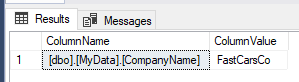

In [63]:

Image(filename='C:/Users/ryans/OneDrive/Desktop/find_string_in_all_tables1.PNG',width=300, height=150)


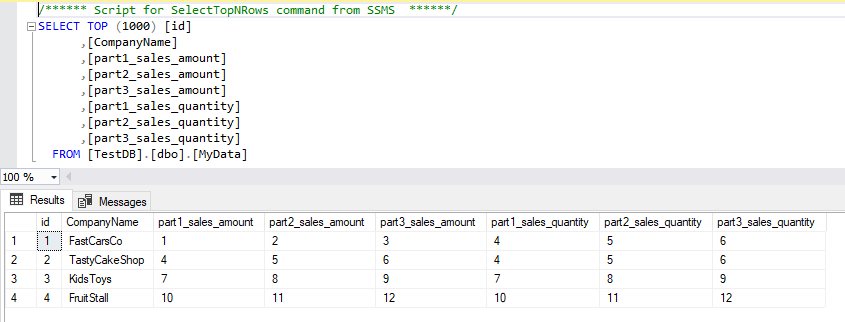

In [66]:


Image(filename='C:/Users/ryans/OneDrive/Desktop/find_string_in_all_tables2.PNG',width=800, height=400)


In [ ]:

Find the size of all the tables in your database.



SELECT 
    t.NAME AS TableName,
    p.rows AS RowCounts,
    SUM(a.total_pages) * 8 AS TotalSpaceKB, 
    SUM(a.used_pages) * 8 AS UsedSpaceKB, 
    (SUM(a.total_pages) - SUM(a.used_pages)) * 8 AS UnusedSpaceKB
FROM 
    sys.tables t
INNER JOIN      
    sys.indexes i ON t.OBJECT_ID = i.object_id
INNER JOIN 
    sys.partitions p ON i.object_id = p.OBJECT_ID AND i.index_id = p.index_id
INNER JOIN 
    sys.allocation_units a ON p.partition_id = a.container_id
WHERE 
    t.NAME NOT LIKE 'dt%' 
    AND t.is_ms_shipped = 0
    AND i.OBJECT_ID > 255 
GROUP BY 
    t.Name, p.Rows
ORDER BY 
    t.Name


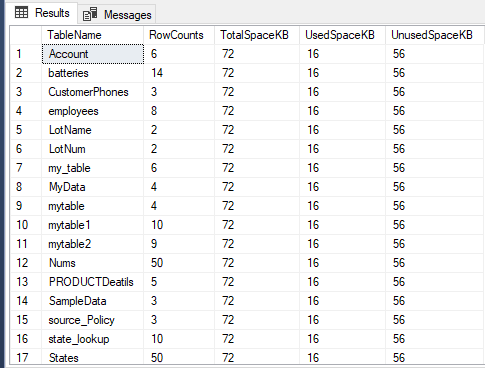

In [41]:

Image(filename='C:/Users/ryans/OneDrive/Desktop/sizes_of_all_tables.PNG',width=500, height=250)


In [ ]:

Fill down from prior record if current record is missing.



DROP TABLE #C
CREATE TABLE #C (SomeData CHAR(1) , ID INT)
INSERT INTO #C values('A', 1)
INSERT INTO #C values(NULL, 2)
INSERT INTO #C values('B', 3)
INSERT INTO #C values('C', 4)
INSERT INTO #C values(NULL, 5)
INSERT INTO #C values('D', 6)


Select * From #C

SELECT CASE WHEN SomeData is not null
            THEN SomeData
            ELSE (SELECT max(SomeData)
                  FROM #C
                  WHERE ID <= t.ID)
       END AS SomeData, ID
FROM #C t 


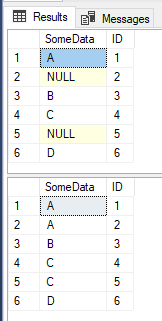

In [45]:

from IPython.display import Image
Image(filename='C:/Users/ryans/OneDrive/Desktop/fill_down.PNG',width=200, height=100)
   

In [ ]:

The Common Table Expressions (CTE) were introduced into standard SQL in 2005.  The structure of the recursive CTE in Transact-SQL is similar to recursive routines in other programming languages.  Although a recursive routine in other languages returns a scalar value, a recursive CTE can return multiple rows.  You can also use a CTE as a temporary named result set that you can reference within a SELECT, INSERT, UPDATE, or DELETE statement.  Much like a derived table, the result of a CTE is not stored and exists only for the duration of the query, and then it is deleted.

Let's try to extract only numeric characters from a field.



CREATE FUNCTION dbo.udf_GetNumeric
(
  @strAlphaNumeric VARCHAR(256)
)
RETURNS VARCHAR(256)
AS
BEGIN
  DECLARE @intAlpha INT
  SET @intAlpha = PATINDEX('%[^0-9]%', @strAlphaNumeric)
  BEGIN
    WHILE @intAlpha > 0
    BEGIN
      SET @strAlphaNumeric = STUFF(@strAlphaNumeric, @intAlpha, 1, '' )
      SET @intAlpha = PATINDEX('%[^0-9]%', @strAlphaNumeric )
    END
  END
  RETURN ISNULL(@strAlphaNumeric,0)
END
GO


In [ ]:

DROP TABLE SampleData -- If it already exists...

Create table SampleData
(id int, factor varchar(100))

insert into SampleData values (1 ,'AAA 1.058 (Protection Class)')
insert into SampleData values (2, 'BBB0.565 (Construction) ')
insert into SampleData values ( 3, 'CCCCC   1.04890616 (Building Limit Rel')


In [ ]:

Select * From SampleData
  

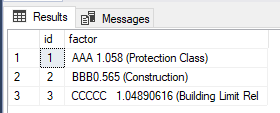

In [23]:

Image(filename='C:/Users/ryans/OneDrive/Desktop/select_all.PNG',width=300, height=150)
 

In [ ]:

Select id, factor, dbo.udf_GetNumeric(factor)
From   SampleData


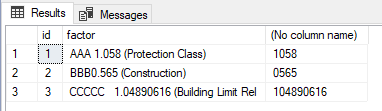

In [25]:

Image(filename='C:/Users/ryans/OneDrive/Desktop/select_numbers1.PNG',width=400, height=200)
 

In [ ]:

Given a quick look, this looks promising.  All the alpha characters have been stripped out, and only number remain.  However, the decimls are gone, so 1.058 became 1058 and 0.565 has become 0565.  This is completely wrong.  Let's try a slightly different approach.


In [ ]:

;with processTable as (
    select id, factor, num    
    from SampleData    
  
           cross apply (
            select (select C + ''
            from (select N, substring(factor, N, 1) C from (values(1),(2),(3),(4),(5),(6),(7),(8),(9),(10),(11),(12)) Num(N)   where N<=datalength(factor)) t
            where PATINDEX('%[0-9.]%',C)> 0
            order by N
            for xml path(''))
        ) p0 (num)  
) 


SELECT id, factor, num
FROM processTable


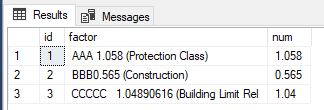

In [26]:

Image(filename='C:/Users/ryans/OneDrive/Desktop/select_numbers2.PNG',width=400, height=200)


In [ ]:

The image above looks good, but 1.04890616 is truncated to 1.04

Let's make one more attempt to get full percision of all numbers



select s.*, v2.numstr
from sampledata s cross apply
     (values (stuff(factor, 1, patindex('%[0-9]%', factor) - 1, ''))) v(str) cross apply
     (values (left(v.str, patindex('%[^0-9.]%', v.str + 'x') - 1))) v2(numstr);

        
        
PS, thanks for the help with this one Gordon Linoff!

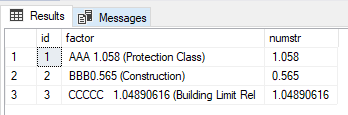

In [27]:

Image(filename='C:/Users/ryans/OneDrive/Desktop/select_numbers3.PNG',width=400, height=200)

We got it!!

In [ ]:

Let's grab only alpha characters from a field, and agnore all numeric data.



DROP FUNCTION dbo.udf_GetAlpha
CREATE FUNCTION dbo.udf_GetAlpha
(
  @strAlphaNumeric VARCHAR(256)
)
RETURNS VARCHAR(256)
AS
BEGIN
  DECLARE @intAlpha INT
  SET @intAlpha = PATINDEX('%[^a-z]%', @strAlphaNumeric)
  BEGIN
    WHILE @intAlpha > 0
    BEGIN
      SET @strAlphaNumeric = STUFF(@strAlphaNumeric, @intAlpha, 1, '' )
      SET @intAlpha = PATINDEX('%[^a-z]%', @strAlphaNumeric )
    END
  END
  RETURN ISNULL(@strAlphaNumeric,0)
END
GO

Select id, factor, dbo.udf_GetAlpha(factor)
From   SampleData


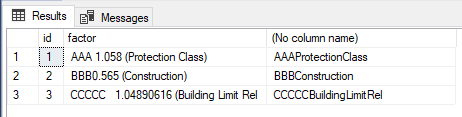

In [38]:

Image(filename='C:/Users/ryans/OneDrive/Desktop/get_alphas.PNG',width=400, height=200)


In [ ]:

Ok, this is decent, but not perfect.  Some words are concatenated together, and it's not totally intuitive, but it basically does what it is supposed to do.  We may have hit a wall here.  The take away, is that SQL isn't a programming language, like Python or Java, but it is very useful for interacting with relational database management systems.


In [ ]:

Let's have some fun with Pivots!



Create table SampleData
(Income VARCHAR(20), Expenses VARCHAR(20), Other VARCHAR(20), Department VARCHAR(20), Date [Date])

insert into SampleData values ('2k', '4k', '.5k','Marketing', '2014-05-28')
insert into SampleData values ('52k', '7k', '.1k','Sales', '2014-04-01')


SELECT * FROM SampleData


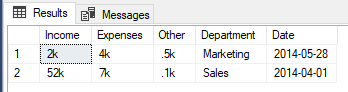

In [32]:

Image(filename='C:/Users/ryans/OneDrive/Desktop/no_pivot.PNG',width=400, height=200)


In [ ]:

First, let's unpivot our table.



SELECT Description, Value, Department, Date 
FROM SampleData T
UNPIVOT ([Value] FOR [Description] IN ([Income], [Expenses], [Other])) AS UNPVT


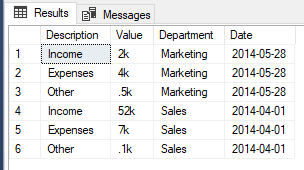

In [34]:

Image(filename='C:/Users/ryans/OneDrive/Desktop/unpivot.PNG',width=300, height=150)


In [ ]:

Let's create a temp table, and create a pivot from that table



SELECT Description, Value, Department, Date 
Into #Test
FROM SampleData T
UNPIVOT ([Value] FOR [Description] IN ([Income], [Expenses], [Other])) AS UNPVT

Select * From #Test


In [ ]:
Let's pivot some data based on the temp table that we just created.



Select * From (SELECT [Value], [Description], [Department]
FROM #Test) t
PIVOT (Count([Description])
For [Description] IN ([Income],[Expense],[Other])) as Pvt
               

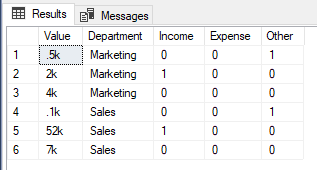

In [35]:

Image(filename='C:/Users/ryans/OneDrive/Desktop/pivot.PNG',width=300, height=150)


In [ ]:

Notice: we can use Conditional Aggregation to do the same thing.
    
    
    
SELECT Value, Department,
       Sum(CASE WHEN Description = 'Income' THEN 1 ELSE 0 END) Income,
       Sum(CASE WHEN Description = 'Expense' THEN 1 ELSE 0 END) Expense,
       Sum(CASE WHEN Description = 'Other' THEN 1 ELSE 0 END) Other
FROM #Test
GROUP BY Value, Department


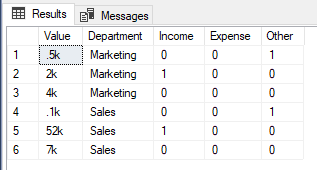

In [36]:

Image(filename='C:/Users/ryans/OneDrive/Desktop/pivot.PNG',width=300, height=150)


In [ ]:

This pivoting stuff is fnu!  Let's look at one more example, using Dynamic SQL.
What is the advantage of using Dynamic SQL?



-- Drop Table tempTable

-- Start creating all objects for Dyanmic Pivot
DECLARE @query VARCHAR(4000)
DECLARE @Dept VARCHAR(2000)
SELECT  @Dept = STUFF(( SELECT Distinct '],[' + [Department]
            FROM    [#Test]
            ORDER BY '],[' + [Department]
            FOR XML PATH('')
            ), 1, 2, '') + ']'
SET @query =
-- Objects that are created above, are put into the table you are about to create below
'SELECT * INTO tempTable FROM (SELECT * FROM
(
    SELECT [Description],[Value],[Department]
    FROM [#Test]
)t
PIVOT (MAX([Value]) FOR [Department]
IN ('+@Dept+')) AS pvt) X'
-- Print(@query)
EXECUTE (@query)

-- Select everything from the dynamically created table ('tempTable') to see results
Select * from tempTable
        

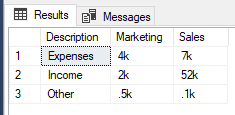

In [37]:

Image(filename='C:/Users/ryans/OneDrive/Desktop/dynamic_sql.PNG',width=300, height=150)


In [ ]:

The main advantage of Dynamic SQL, is that it permits a client application to act interactively, passing different information at different times to the open server application, from the user. The Open Server application can then fill in the missing pieces in the SQL query with the data the user provides.  In this example, the 'Department' was not explicitly defined, but rather created dynamically, from this: '+@Dept+'.  In this scenario, we knew there were just two departments, but what if new departments are always created and sometimes removed.  Static SQL will never pickup these changes, but Dynamic SQL will!  A couple disadvantages of using Dynamic SQL, are that it's slower than running Static SQL and, as you can tell from the example shown above, it's kind of hard to write SQL in this fashion.


In [ ]:

We have seen some pretty interesting, and very useful, SQL scripts here.  Let's finish things off with queries to find duplicate records, and more mportantly, delete duplicate records (there is no legitimate reason to have duplicate records in a table).

CREATE TABLE Employee
( 
[ID] INT identity(1,1), 
[FirstName] Varchar(100), 
[LastName] Varchar(100), 
[Country] Varchar(100), 
) 
GO 
    
Insert into Employee ([FirstName],[LastName],[Country] )values('Raj','Gupta','India'),
('Raj','Gupta','India'),
('Mohan','Kumar','USA'),
('James','Barry','UK'),
('James','Barry','UK'),
('James','Barry','UK')

Select * From Employee


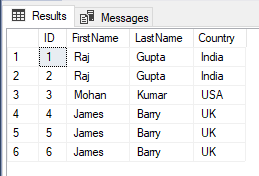

In [44]:

Image(filename='C:/Users/ryans/OneDrive/Desktop/dupes.PNG',width=300, height=150)


In [ ]:

We can use some CTE logic to find dupes for us.



WITH CTE([firstname], 
    [lastname], 
    [country], 
    duplicatecount)
AS (SELECT [firstname], 
           [lastname], 
           [country], 
           ROW_NUMBER() OVER(PARTITION BY [firstname], 
                                          [lastname], 
                                          [country]
           ORDER BY id) AS DuplicateCount
    FROM [Employee])
SELECT *
FROM CTE


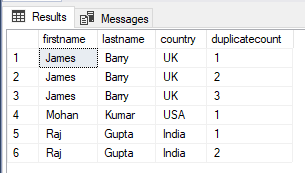

In [57]:

Image(filename='C:/Users/ryans/OneDrive/Desktop/dupes_counted.PNG',width=300, height=150)


In [ ]:

We can remove dupes with this CTE.



WITH CTE([FirstName], 
    [LastName], 
    [Country], 
    DuplicateCount)
AS (SELECT [FirstName], 
           [LastName], 
           [Country], 
           ROW_NUMBER() OVER(PARTITION BY [FirstName], 
                                          [LastName], 
                                          [Country]
           ORDER BY ID) AS DuplicateCount
    FROM [Employee])
DELETE FROM CTE
WHERE DuplicateCount > 1

Select * From Employee


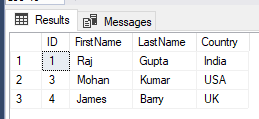

In [58]:

Image(filename='C:/Users/ryans/OneDrive/Desktop/dupes_removed.PNG',width=300, height=150)


In [ ]:

DROP TABLE Employee
CREATE TABLE Employee
( 
[ID] INT identity(1,1), 
[FirstName] Varchar(100), 
[LastName] Varchar(100), 
[Country] Varchar(100), 
) 
GO 
    
Insert into Employee ([FirstName],[LastName],[Country])values('Raj','Gupta','India'),
('Raj','Gupta','India'),
('Mohan','Kumar','USA'),
('James','Barry','UK'),
('James','Barry','UK'),
('James','Barry','UK')

Select * From Employee


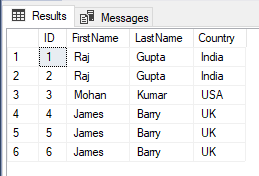

In [59]:

Image(filename='C:/Users/ryans/OneDrive/Desktop/dupes.PNG',width=300, height=150)


In [ ]:

Of course, as with all things in the world of technology, there are multiple ways to do the same thing.


In [ ]:

WITH CTE AS(
   SELECT [FirstName],[LastName],[Country],
       RN = ROW_NUMBER()OVER(PARTITION BY [FirstName] ORDER BY [FirstName])
   FROM Employee
)
DELETE FROM CTE WHERE RN > 1

Select * From Employee


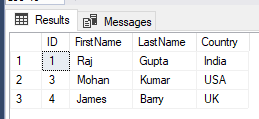

In [60]:

Image(filename='C:/Users/ryans/OneDrive/Desktop/dupes_removed.PNG',width=300, height=150)


In [ ]:

The two scripts below will do also delete dupes, just like we did in the example above.



WITH CTE AS
(
SELECT *,ROW_NUMBER() OVER (PARTITION BY [FirstName],[LastName],[Country] ORDER BY [FirstName],[LastName],[Country]) AS RN
FROM Employee
)

DELETE FROM CTE WHERE RN<>1



...or...



WITH CTE AS
(SELECT *,R=RANK() OVER (ORDER BY [FirstName],[LastName],[Country])
FROM Employee)
 
DELETE CTE
WHERE R IN (SELECT R FROM CTE GROUP BY R HAVING COUNT(*)>1)


In [ ]:

Let's say you have a table with some unique values and some duplicates.  Normally, if the records were duped, you could use the 'distinct' clause to pick out the unique records, but sometimes the 'distinct' clause doesn't do the job, because ALL records in all columns have to be distinct for it to work correctly.  Basically, the row_number Windows Function generates a new row number for every row, regardless of duplicates within a partition.  Once we can identify unique rows, we can start to perform operations on those rows, like selecting the first row for each partition.



-- Drop Table Account --- If necessary...
CREATE TABLE Account
( sid  VARCHAR(100) NOT NULL,
  id VARCHAR(100) NOT NULL,
  rNum VARCHAR(100) NOT NULL,
  str VARCHAR(100) NOT NULL,
  power VARCHAR(100) NOT NULL,
  con1 VARCHAR(100) NOT NULL,
  rc VARCHAR(100) NOT NULL)

--Delete from Account

INSERT INTO dbo.Account
  (sid, id, rNum, str, power, con1, rc)
VALUES
  ('15', '287', '6', 'Grit', '0', '0', '225')
INSERT INTO dbo.Account
  (sid, id, rNum, str, power, con1, rc)
VALUES
  ('15', '288', '6', 'Grit', '0', '0', '225')
  INSERT INTO dbo.Account
  (sid, id, rNum, str, power, con1, rc)
VALUES
  ('15', '289', '6', 'Grit', '0', '0', '225')
  INSERT INTO dbo.Account
  (sid, id, rNum, str, power, con1, rc)
VALUES
  ('16', '287', '6', 'Grit', '0', '0', '222')
  INSERT INTO dbo.Account
  (sid, id, rNum, str, power, con1, rc)
VALUES
  ('17', '287', '6', 'Grit', '0', '0', '656')

Select * 
From Account


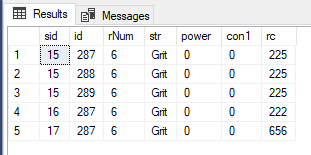

In [67]:

Image(filename='C:/Users/ryans/OneDrive/Desktop/rn_before.PNG',width=300, height=150)


In [ ]:

select distinct sid, id, rNum, str, power, con1, rc
from Account


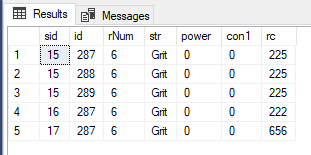

In [69]:

By this query, you get the same result as the image above, because all the records from each column of data, collectively, is distinct.



Image(filename='C:/Users/ryans/OneDrive/Desktop/rn_before.PNG',width=300, height=150)


In [ ]:

So, ROW_NUMBER() is a window function that assigns a sequential integer number to each row in the query’s result set.  When each row in each partition is assigned a sequential integer number called a row number, we can choose the first row number, and we will get our desired results.



select *
from (
    select t.*, row_number() over(partition by sid order by id) rn
    from Account t
) t
where rn = 1


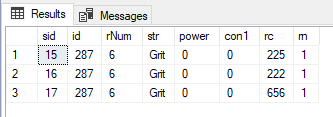

In [68]:

Image(filename='C:/Users/ryans/OneDrive/Desktop/rn_after.PNG',width=300, height=150)
